In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
with open("train.csv","r") as f:
    df = pd.read_csv(f)
#欠損値の確認
df.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64

In [4]:
with open("test.csv","r") as f:
    df_test = pd.read_csv(f)
#欠損値の確認
df.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    4
disease     0
dtype: int64

id：(int)ID  
Age：(int)年齢  
Gender：(char)性別  
T_Bil：(float)総ビリルビン  
D_Bil:(float)直接ビリルビン  
ALP:(float)アルカリフォスファター ゼ  
ALT_GPT:(float)アラニンアミノトランスフェラーゼ        
AST_GOT:(float)アスパラギン酸アミノトランスフェラーゼ         
TP:(float)総タンパク   
Alb:(float)アルブミン           
AG_ratio:(float)アルブミン/グロブリン比       
disease:(int)肝疾患の有無（0:無, 1:有）   

欠損の補完方法  
平均値・中央値・最頻値・予測値

In [5]:
df.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


In [6]:
df.AG_ratio.mean()
#df.AG_ratio.median()
#df.AG_ratio.mode()
#df.AG_ratio.hist(bins = 100)
#df.describe()

0.9978579481397972

In [7]:
#欠損データを列AG_ratioの平均値で補完
train_data = df.fillna(1.00)

In [8]:
train_data.isnull().sum()

id          0
Age         0
Gender      0
T_Bil       0
D_Bil       0
ALP         0
ALT_GPT     0
AST_GOT     0
TP          0
Alb         0
AG_ratio    0
disease     0
dtype: int64

In [9]:
#文字列を値に置き換える
train_data = train_data.replace("Male", 1)
train_data = train_data.replace("Female", 0)

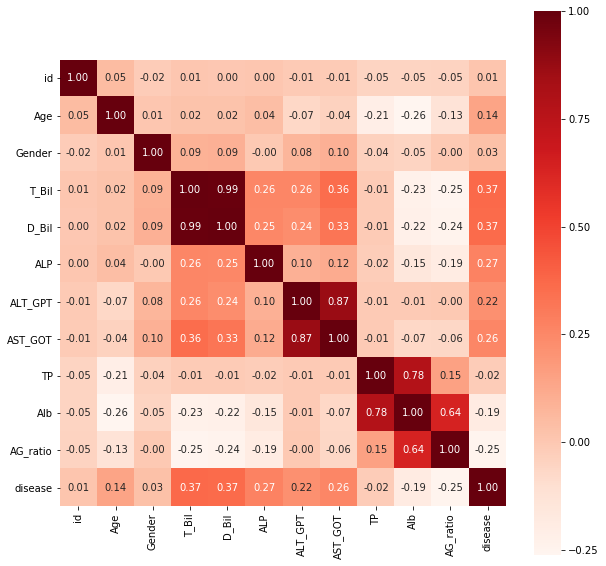

In [10]:
plt.figure(figsize=(10, 10))
sns.heatmap(train_data.corr(), square=True, annot=True, fmt=".2f", cmap ="Reds")

In [44]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_data, test_size=0.1)

In [45]:
# IDは使わない
train_X = train.iloc[:,1:-1]
train_y = train["disease"]
test_X = test.iloc[:,1:-1]
test_y = test["disease"]
train_X.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
606,45,1,1.2,0.1,245.2,21.8,24.1,7.0,3.4,1.08
428,48,0,1.0,0.1,174.8,23.9,53.9,5.4,2.7,0.91
102,22,1,0.9,0.4,179.0,17.9,21.0,6.6,3.6,1.17
277,34,1,2.0,1.1,226.0,32.9,135.0,6.2,2.7,0.82
869,36,1,3.2,1.5,305.1,28.0,75.9,5.9,2.4,0.70


# RandomForest

In [46]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=23, random_state=5)
clf.fit(train_X, train_y)
#print(clf.feature_importances_)
clf.score(train_X, train_y)

[0.08742048 0.01419747 0.20834221 0.09406393 0.15813313 0.1037579
 0.15611605 0.05539339 0.0535817  0.06899375]


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [47]:
clf.score(test_X, test_y)

0.9222222222222223

# CatBoost

In [54]:
# 分類用のインスタンスを作成
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
model = CatBoostClassifier(iterations=5000,
                                                use_best_model=True,       # 最も精度が高かったモデルを使用するかの設定
                                                eval_metric='Accuracy')
param_grid = {'depth': [4, 5, 6,7,8,9],
         'learning_rate' : [0.01, 0.1, 0.15],
         'l2_leaf_reg': [1,2,3,4],
         'iterations': [200,300, 500,1000]}
# パラメータチューニングをグリッドサーチで行うために設定する
## このGridSearchCV には注意が必要 scoring は そのスコアを基準にして最適化する
skf = StratifiedKFold(n_splits=10,
                      shuffle=True,
                      random_state=0)
grid_result = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'accuracy',
                           cv = skf,
                           verbose=3,
                           return_train_score = True,
                           n_jobs = -1)
# CatBoost, CatBoostRegressorも存在するが損失関数が異なるだけ
# CatBoostClassifierの損失関数はlog_lossデフォルト

In [ ]:
grid_result.fit(train_X,train_y,
          eval_set=(test_X, test_y),    # 検証用データ
          early_stopping_rounds=1000,  # 10回以上精度が改善しなければ中止
          plot=True)                 # 誤差の推移を描画するか否かの設定

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 50.5min


In [50]:
grid_result.score(test_X, test_y)

0.9333333333333333

In [51]:
#使用するデータの読み込み
df_test = pd.read_csv('test.csv')
test_data = df_test.replace("Male", 1)
test = test_data.replace("Female", 0)
test = test.iloc[:,1:]
#予測を実施
pred = model.predict(test)
pred_df = pd.DataFrame()
pred_df['pred'] = pred
#今後のワークで、この形式でファイルを提出いただく予定です
pred_df.to_csv('./pred.csv')